# NBA Three-Point Shooting Sentiment Analysis

**Author:** Charity Smith  
**Date:** 26 April 2025

### Notebook Description
This notebook analyzes Reddit discussions about NBA three-point shooting to explore how public sentiment has evolved over time. 

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.stats import linregress

In [5]:
# Load the data
reddit_df = pd.read_csv("../data/reddit_data/nba_three_point_sentiment.csv")

# Preview
reddit_df.head()

,type,subreddit,title,content,created,score,num_comments,sentiment_score
0,post,nba,[Marc Stein] “The Kroenkes have a fondness for...,Source: https://marcstein.substack.com/p/the-i...,2025-04-12 10:15:12,596,179.0,-6.796157e-02
1,comment,nba,[Marc Stein] “The Kroenkes have a fondness for...,the kroenkes won't trade MIchael Porter Jr. be...,2025-04-12 10:18:52,1328,NaN,3.000000e-01
2,comment,nba,[Marc Stein] “The Kroenkes have a fondness for...,lol reminds me of the rumor that Jeanie would ...,2025-04-12 10:17:32,376,NaN,6.500000e-01
3,comment,nba,[Marc Stein] “The Kroenkes have a fondness for...,This is such a stupid reason lol,2025-04-12 10:18:46,146,NaN,3.700743e-17
4,comment,nba,[Marc Stein] “The Kroenkes have a fondness for...,"Are you kidding me, fucking Michael Porter Jun...",2025-04-12 13:47:59,20,NaN,-5.000000e-02


In [21]:
# Data Cleaning
# Standard stop words
stop_words = set(stopwords.words('english'))

# Expand with irrelevant or common NBA chatter words (custom)
custom_words = {
    "nba", "game", "player", "players", "team", "teams", "play", "playing", "season", "games",
    "even", "get", "got", "still", "one", "like", "would", "really", "make", "made",
    "know", "see", "watch", "also", "much", "many", "every", "thing", "things",
    "year", "years", "time", "back", "never", "way", "well", "good", "bad",
    "came", "want", "though", "think", "say", "saying", "https", "http", "web",
    "need", "going,", "next", "need", "go"
}
stop_words.update(custom_words)

# Combine 'title' and 'content' into one field for sentiment
reddit_df["text"] = reddit_df["title"].fillna('') + " " + reddit_df["content"].fillna('')

# Enhanced stop word removal function
def remove_stop_words(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(filtered_tokens)

# Apply the cleaning
reddit_df["text"] = reddit_df["text"].apply(remove_stop_words)

In [22]:
# Filter for 3-Point Related Content
# Simple keyword filter: "3pt", "three", "3 pointer", "three-pointer", "three point", etc.
keywords = ["3pt", "three", "3 pointer", "three-pointer", "three point", "three-point shooting"]

# Keep only posts/comments containing one of these keywords (case insensitive)
mask = reddit_df["text"].str.contains('|'.join(keywords), case=False, na=False)
three_point_df = reddit_df[mask].copy()

print(f"Number of posts/comments mentioning 3-pointers: {len(three_point_df)}")
three_point_df.head()

Number of posts/comments mentioning 3-pointers: 5714


,type,subreddit,title,content,created,score,num_comments,sentiment_score,text
0,post,nba,[Marc Stein] “The Kroenkes have a fondness for...,Source: https://marcstein.substack.com/p/the-i...,2025-04-12 10:15:12,596,179.0,-0.067962,marc stein kroenkes fondness porter stems deep...
5,comment,nba,[Marc Stein] “The Kroenkes have a fondness for...,50/40/80 shooter who set a career best for bot...,2025-04-12 10:21:36,106,NaN,0.024791,marc stein kroenkes fondness porter stems deep...
175,post,nba,[OC] Tracking NBA MVP & Awards Votes (SGA 2 - ...,SGA is the betting favorite to win his first M...,2025-04-11 18:15:12,46,29.0,0.086904,oc tracking mvp awards votes sga jokić predict...
196,comment,nba,[OC] Tracking NBA MVP & Awards Votes (SGA 2 - ...,I assume they will announce that after they an...,2025-04-14 13:09:14,2,NaN,-0.162500,oc tracking mvp awards votes sga jokić predict...
203,post,nba,"[NBA.com] Kia MVP Ladder: In final analysis, i...",[Source](https://www.nba.com/news/kia-mvp-ladd...,2025-04-11 10:47:55,0,97.0,0.251150,kia mvp ladder final analysis shai nikola joki...


In [23]:
# Sentiment Analysis Using VADER
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
three_point_df["sentiment"] = three_point_df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Preview
three_point_df[["text", "sentiment"]].head()

,text,sentiment
0,marc stein kroenkes fondness porter stems deep...,-0.8225
5,marc stein kroenkes fondness porter stems deep...,0.8126
175,oc tracking mvp awards votes sga jokić predict...,0.9986
196,oc tracking mvp awards votes sga jokić predict...,0.9100
203,kia mvp ladder final analysis shai nikola joki...,0.9985


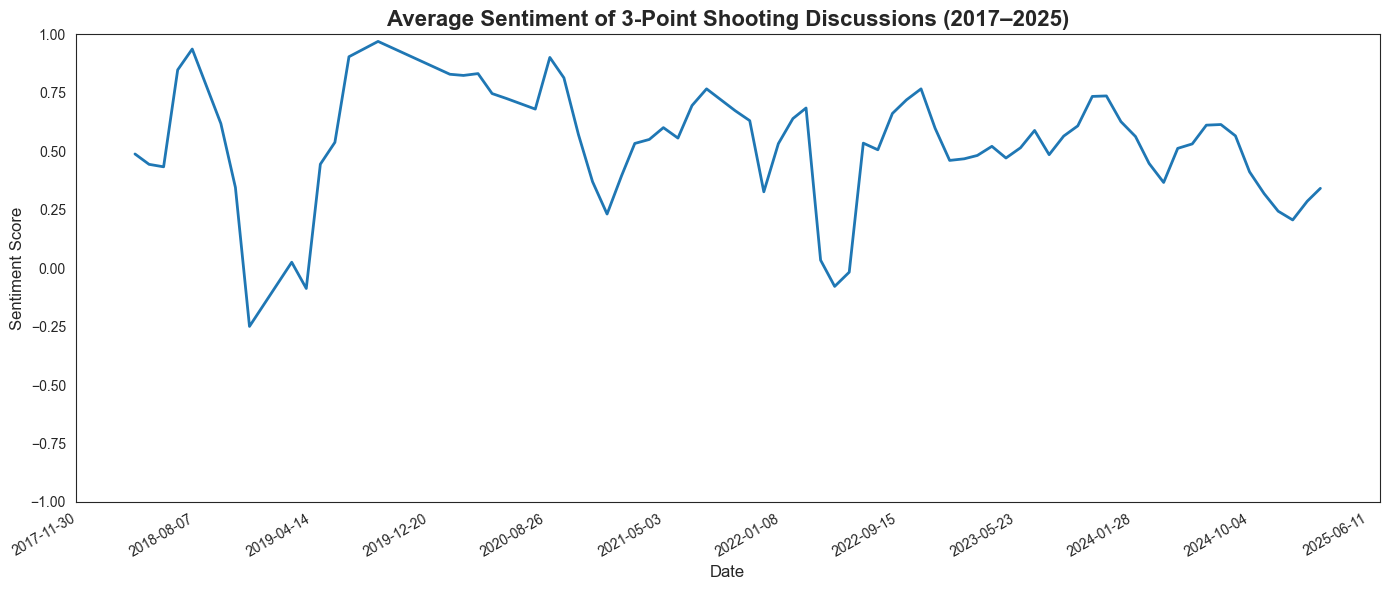

In [24]:
# Sentiment Trend Plot
# Make created as datetime
three_point_df["created"] = pd.to_datetime(three_point_df["created"])
three_point_df["year_month"] = three_point_df["created"].dt.to_period("M").astype(str)

# Group and smooth
sentiment_trend = (
    three_point_df.groupby("year_month")["sentiment"]
    .mean()
    .reset_index()
    .sort_values("year_month")
)
sentiment_trend["sentiment_smoothed"] = sentiment_trend["sentiment"].rolling(window=3, center=True).mean()

# Convert year_month to datetime for proper plotting
sentiment_trend["date"] = pd.to_datetime(sentiment_trend["year_month"])

# Plot
plt.figure(figsize=(14, 6))

# Use "white" style to remove gridlines
sns.set_style("white")
sns.lineplot(data=sentiment_trend, x="date", y="sentiment_smoothed", linewidth=2)

# Format x-axis labels and ensure rotation
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  # Show ~12 ticks
plt.gcf().autofmt_xdate()  # Auto rotate dates

# Labels and formatting
plt.title("Average Sentiment of 3-Point Shooting Discussions (2017–2025)", fontsize=16, weight="bold")  # Descriptive title with time range
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.ylim(-1, 1)

# Remove gridlines for a cleaner look
plt.grid(False)

# Ensure a proper aspect ratio and layout
plt.tight_layout()

# Save and show plot
plt.savefig("../visualizations/avg_sentiment_over_time_improved.png", dpi=300)
plt.show()

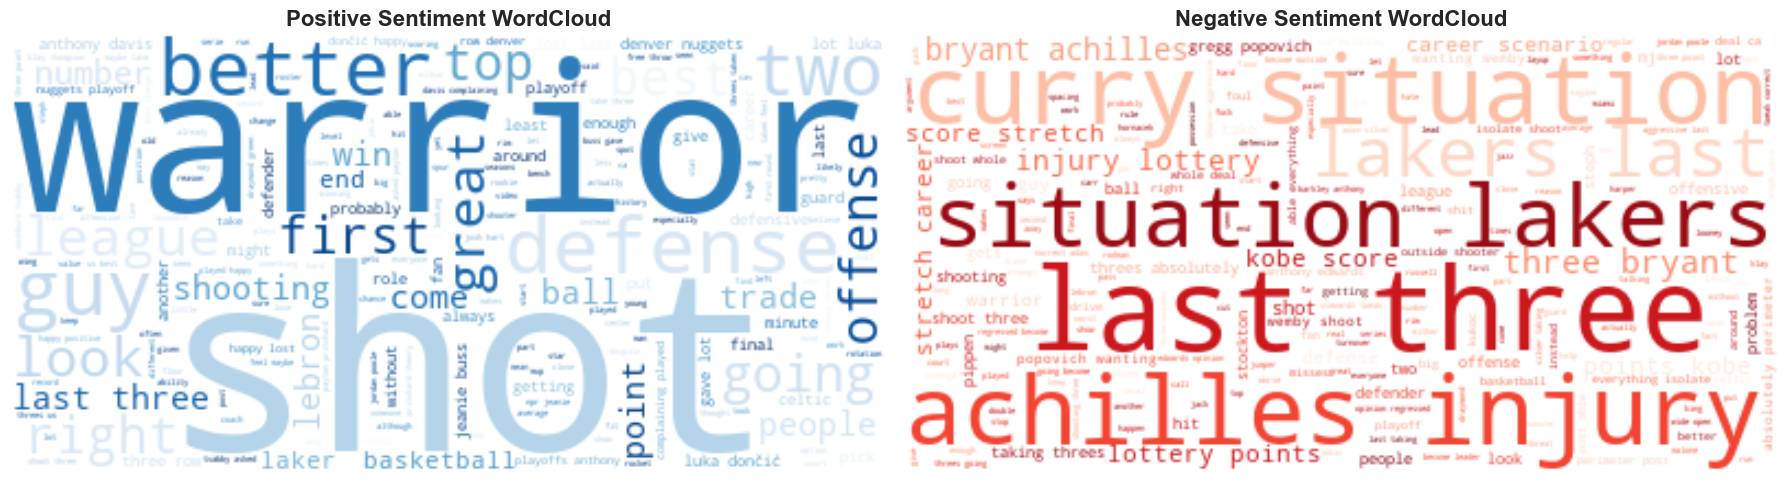

In [25]:
# Wordclouds
positive_text = ' '.join(three_point_df[three_point_df["sentiment"] > 0.2]["text"])
negative_text = ' '.join(three_point_df[three_point_df["sentiment"] < -0.2]["text"])

fig, axes = plt.subplots(1, 2, figsize=(18,8))

wordcloud_pos = WordCloud(background_color='white', colormap='Blues').generate(positive_text)
wordcloud_neg = WordCloud(background_color='white', colormap='Reds').generate(negative_text)

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Sentiment WordCloud', fontsize=16, weight='bold')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Sentiment WordCloud', fontsize=16, weight='bold')

plt.tight_layout()

# Save and show plot
plt.savefig("../visualizations/word_clouds.png", dpi=300)
plt.show()

In [14]:
# Trend Analysis Using Linear Regression
# Remove missing values before regression
clean_trend = sentiment_trend.dropna(subset=["sentiment_smoothed"]).copy()

# Convert dates to ordinal format (for regression)
clean_trend["date_ordinal"] = clean_trend["date"].map(pd.Timestamp.toordinal)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    clean_trend["date_ordinal"], clean_trend["sentiment_smoothed"]
)

# Print results
print(f"Sentiment trend slope: {slope:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Interpret
if p_value < 0.05:
    print("✅ There is a significant trend over time.")
    print("📈 Positive slope" if slope > 0 else "📉 Negative slope")
else:
    print("No significant trend in sentiment over time.")


Sentiment trend slope: -0.0000
p-value: 0.3486
R-squared: 0.0122
No significant trend in sentiment over time.


### Sentiment Trend Analysis:

- **Sentiment Trend Slope**: **-0.0000**
  - The slope is nearly zero, indicating that there is almost no change in sentiment over time.

- **p-value**: **0.3486**
  - The p-value is greater than 0.05, suggesting that the trend is **not statistically significant**. This means the observed sentiment changes over time could likely be due to random variation, rather than a real trend.

- **R-squared**: **0.0122**
  - The **R-squared value** is very low (1.22%), indicating that sentiment over time explains very little of the variability in the data.

### Conclusion:
- Based on the results, there is **no significant trend in sentiment over time**. The low p-value and R-squared value suggest that sentiment is relatively stable and does not show a meaningful upward or downward movement across the time period analyzed.


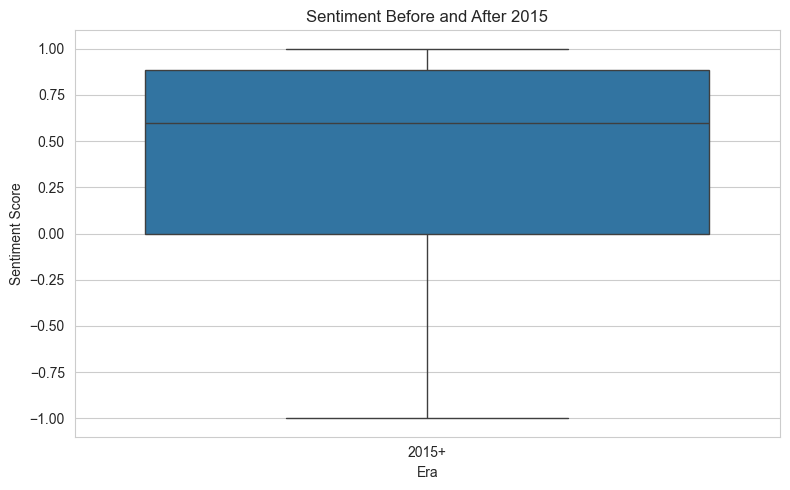

T-test statistic: nan, p-value: nan


/var/folders/nc/ynm8w4053qg59qhr2zcdcpyh0000gn/T/ipykernel_98924/2296567557.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_val = ttest_ind(pre, post)


In [15]:
# Compare Sentiment Before/After a Key Year (Steph Curry 2015)
# Compare sentiment before and after 2015
three_point_df["created"] = pd.to_datetime(three_point_df["created"])
three_point_df["era"] = three_point_df["created"].dt.year.apply(lambda x: "Pre-2015" if x < 2015 else "2015+")

# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=three_point_df, x="era", y="sentiment")
plt.title("Sentiment Before and After 2015")
plt.ylabel("Sentiment Score")
plt.xlabel("Era")
plt.tight_layout()


# Save and show plot
plt.savefig("../visualizations/sentiment_before_after_2015.png", dpi=300)
plt.show()

# T-test
from scipy.stats import ttest_ind

pre = three_point_df[three_point_df["era"] == "Pre-2015"]["sentiment"].dropna()
post = three_point_df[three_point_df["era"] == "2015+"]["sentiment"].dropna()
t_stat, p_val = ttest_ind(pre, post)

print(f"T-test statistic: {t_stat:.4f}, p-value: {p_val:.4f}")


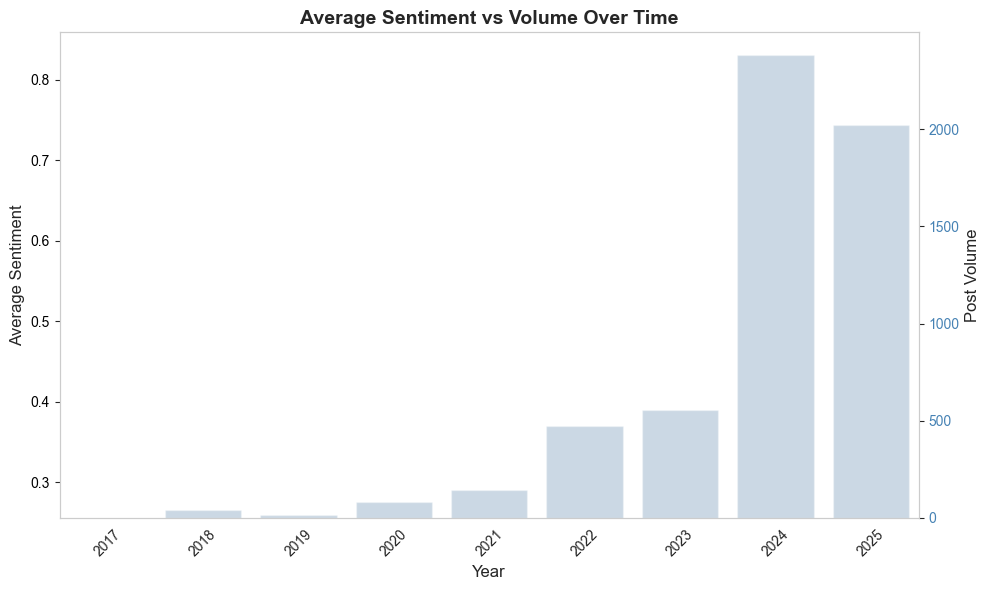

In [16]:
# Sentiment Volume Comparison Over Time
# Count posts per year
volume = (
    three_point_df.groupby(three_point_df["created"].dt.year)
    .agg(num_posts=("sentiment", "count"), avg_sentiment=("sentiment", "mean"))
    .reset_index()
)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Remove gridlines
ax1.grid(False)

# Line for Avg Sentiment
sns.lineplot(
    data=volume,
    x="created",
    y="avg_sentiment",
    ax=ax1,
    label="Avg Sentiment",
    color="black",
    marker="o"
)

# Remove the legend explicitly
ax1.get_legend().remove()

# Bar for post volume
ax2 = ax1.twinx()
sns.barplot(
    data=volume,
    x="created",
    y="num_posts",
    ax=ax2,
    alpha=0.3,
    color="steelblue"
)

# Clean look
ax2.grid(False)
ax1.set_title("Average Sentiment vs Volume Over Time", fontsize=14, weight='bold')
ax1.set_ylabel("Average Sentiment", fontsize=12)
ax2.set_ylabel("Post Volume", fontsize=12)
ax1.set_xlabel("Year", fontsize=12)

# Improve tick formatting
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='steelblue')

plt.tight_layout()

# Save and show plot
plt.savefig("../visualizations/avg_sentiment_vs_volume.png", dpi=300)
plt.show()